In [10]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field

In [2]:
load_dotenv()

True

In [8]:
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [12]:
class SetimentSchema(BaseModel):

 sentiment: Literal["positive","negative"]=Field(description='Sentiment of the review')

In [26]:
class DiagnosisSchema(BaseModel):
    issue_type :Literal["UX","Performance","Bug","Support","Other"]=Field(description='The categoory of review mentioned in the review')
    tone:Literal["frustated","disappointed","calm"]=Field(description="The emotional tone exapressed by the user")
    urgency:Literal["low","medium","high"]=Field(description="How urgent or critical the issue apperas to be")
    

In [28]:
structured_model=model.with_structured_output(SetimentSchema)
structured_model2=model.with_structured_output(DiagnosisSchema)

In [16]:
prompt="What is the sentiment of the following review-The software is too bad"
model.invoke(prompt).content

'The sentiment of the review "The software is too bad" is strongly **negative**.'

In [17]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive","negative"]
    #dict with: issue type,tione,urgency
    diagnosis:dict
    response:str

In [ ]:
def find_sentiment(state:ReviewState):
    prompt=f"For the following review find out the sentiment \n {state["review"]}"
    sentiment=structured_model.invoke(prompt).sentiment

    return {"sentiment":sentiment}

def check_sentiment(state:ReviewState)->Literal["positive_response","run_diagnosis"]:

    if state['sentiment']=='positive':
        return 'positive_response'
   
    else:
        return 'run_diagnosis'
    
def positive_response(state:ReviewState):


    prompt = f"""Write a warm thank-you message in response to this review:
      \n\n{state['review']}\n
       Also, kindly ask the user to leave feedback on our website."""
    
    response=model.invoke(prompt)

    return {'response':response}

def run_diagnosis(state:ReviewState):

    prompt=f"""Diagnose this negative review:\n\n{state['review']}\n"
       "Return issue_type,one,urgency.
"""
 
 
    response=structured_model2.invoke(prompt)
    #schema stores data in format of json
#model_dump(): json format gets converted to dict
    return {'diagnosis':response.model_dump()}

def negative_response(state:ReviewState):
    diagnosis=state['diagnosis']

    #Need to extract keys of dict
    prompt=f""" You're a support assistant.
         The user had a '{diagnosis['issue_type']}' issue,sounded{diagnosis['tone']},and marked urgency as 
         '{diagnosis['urgency']}'.
         Write an empathetic,helpful resolution message.
         """
    response=model.invoke(prompt).content
    return {'response',response}


In [32]:
graph=StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response',negative_response)


graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)


workflow=graph.compile()


In [35]:
initial_state={
    'review':'The product was not that good'
}
workflow.invoke(initial_state)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:172.217.174.234:443: tcp handshaker shutdown.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:142.250.207.138:443: tcp handshaker shutdown.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:142.250.71.106:443: tcp handshaker shutdown.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 16.0 seconds as it raised RetryError: Timeout of 600.0s exceed

RetryError: Timeout of 600.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNKNOWN: ipv4:142.251.220.10:443: tcp handshaker shutdown

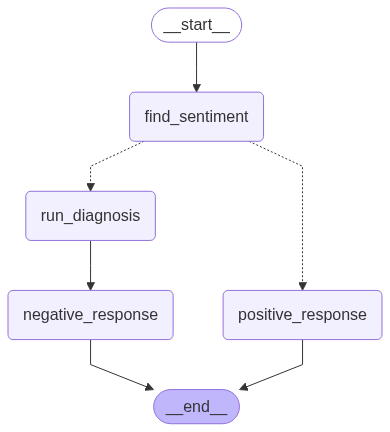

In [33]:
workflow